# Modeling Extremes - Numpyro Pt 1

In [2]:
import autoroot
import ee
import numpy as np
import xarray as xr
import pandas as pd
import pint_xarray
from scipy.stats import rv_histogram, genextreme
from bayesevt._src.geoprocessing.math import safe_reciprocal
from geo_toolz._src.masks.country import add_country_mask
from geo_toolz._src.masks.land import add_land_mask
from geo_toolz._src.masks.ocean import add_ocean_mask
from geo_toolz._src.validation.coords import validate_longitude, validate_latitude
from geo_toolz._src.encoders.time import time_rescale, time_unrescale
from geo_toolz._src.discretize.grid import RegularLonLat
from geo_toolz._src.data.reanalysis.gee import download_era5_gee
from geo_toolz.extremes import calculate_block_maxima_ts, calculate_pot_quantile, calculate_pot_ts, calculate_pp_counts_ts, calculate_pp_stats_ts
from odc.geo.geobox import GeoBox
from odc.geo.geom import Geometry
from odc.geo.crs import CRS

import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS
import xarray as xr
import regionmask

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)


%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

In [3]:
# create bounding box
gbox = RegularLonLat.init_from_country("E", 1/4)

In [4]:
ds = download_era5_gee("era5_daily", gbox)
ds

<xarray.Dataset> Size: 891MB
Dimensions:                     (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time                        (time) datetime64[ns] 121kB 1979-01-02 ... 20...
  * lon                         (lon) float32 204B -9.375 -9.125 ... 2.875 3.125
  * lat                         (lat) float32 128B 43.62 43.38 ... 36.12 35.88
Data variables:
    mean_2m_air_temperature     (time, lon, lat) float32 99MB ...
    minimum_2m_air_temperature  (time, lon, lat) float32 99MB ...
    maximum_2m_air_temperature  (time, lon, lat) float32 99MB ...
    dewpoint_2m_temperature     (time, lon, lat) float32 99MB ...
    total_precipitation         (time, lon, lat) float32 99MB ...
    surface_pressure            (time, lon, lat) float32 99MB ...
    mean_sea_level_pressure     (time, lon, lat) float32 99MB ...
    u_component_of_wind_10m     (time, lon, lat) float32 99MB ...
    v_component_of_wind_10m     (time, lon, lat) float32 99MB ...
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [5]:
def preprocess(ds):
    # select variable
    ds = ds[["maximum_2m_air_temperature"]]
    ds = ds.rename({"maximum_2m_air_temperature": "t2m_max"})
    
    # validate units
    ds = ds.pint.quantify({"t2m_max": "kelvin"})
    ds["t2m_max"] = ds["t2m_max"].pint.to("degC")
    ds = ds.pint.dequantify()
    
    # validate coordinates
    ds = validate_latitude(ds)
    ds = validate_longitude(ds)

    return ds


In [6]:
%%time
# preprocess data
ds = preprocess(ds)
# add country mask
ds = add_country_mask(ds, country="Spain")
ds

CPU times: user 4.43 s, sys: 1.46 s, total: 5.89 s
Wall time: 28.2 s


<xarray.Dataset> Size: 99MB
Dimensions:     (time: 15165, lon: 51, lat: 32)
Coordinates:
  * time        (time) datetime64[ns] 121kB 1979-01-02 1979-01-03 ... 2020-07-09
  * lon         (lon) float32 204B -9.375 -9.125 -8.875 ... 2.625 2.875 3.125
  * lat         (lat) float32 128B 43.62 43.38 43.12 42.88 ... 36.38 36.12 35.88
    spain_mask  (lat, lon) int16 3kB 0 0 0 0 0 1 1 1 1 0 ... 0 0 0 0 0 0 0 0 0 0
Data variables:
    t2m_max     (time, lon, lat) float32 99MB 13.11 13.28 13.21 ... 38.16 37.06
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

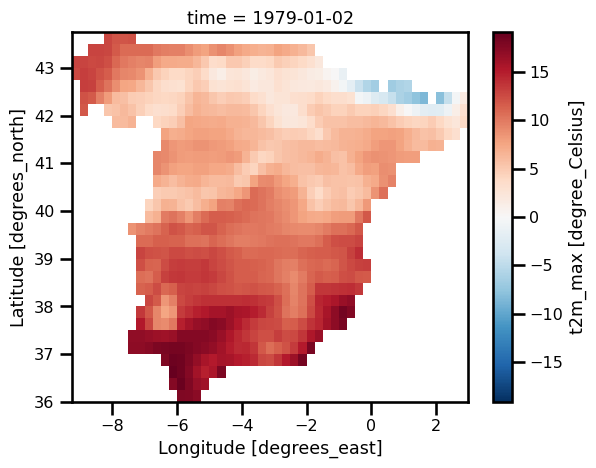

In [7]:
ds.isel(time=0).where(ds.spain_mask==1, drop=True).t2m_max.plot.pcolormesh(x="lon", y="lat")

## Block Maxima Extremes

In [8]:
ds_madrid = ds.sel(lon=-3.703790, lat=40.416775, method="nearest")
ds_madrid

<xarray.Dataset> Size: 182kB
Dimensions:     (time: 15165)
Coordinates:
  * time        (time) datetime64[ns] 121kB 1979-01-02 1979-01-03 ... 2020-07-09
    lon         float32 4B -3.625
    lat         float32 4B 40.38
    spain_mask  int16 2B 1
Data variables:
    t2m_max     (time) float32 61kB 10.84 10.95 8.061 ... 38.24 34.31 32.77
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

In [9]:
extremes_madrid = calculate_block_maxima_ts(ds_madrid, 365)
extremes_madrid

<xarray.Dataset> Size: 502B
Dimensions:     (time: 41)
Coordinates:
  * time        (time) datetime64[ns] 328B 1980-01-19 1981-01-18 ... 2020-01-09
    lon         float32 4B -3.625
    lat         float32 4B 40.38
    spain_mask  int16 2B 1
Data variables:
    t2m_max     (time) float32 164B 39.1 38.5 38.83 38.04 ... 39.78 41.03 39.77
Attributes: (12/36)
    date_range:               [284083200000, 1594252800000]
    description:              <p>ERA5 is the fifth generation ECMWF atmospher...
    keywords:                 ['climate', 'copernicus', 'dewpoint', 'ecmwf', ...
    max_mirrored_version:     1594797432309553
    period:                   1
    period_mapping:           [284083200000, 1594252800000]
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     Daily mean u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

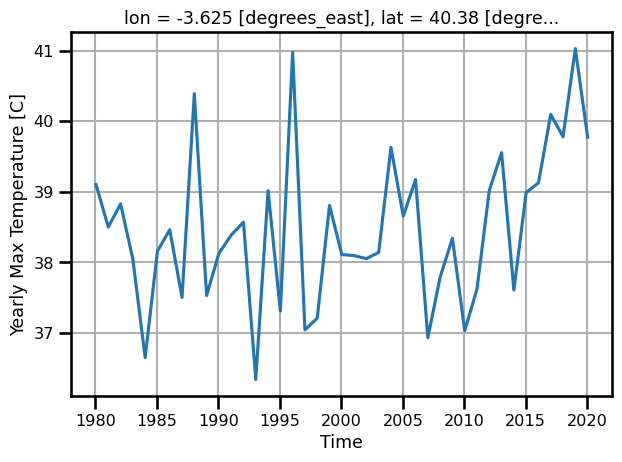

In [10]:
fig, ax = plt.subplots()

extremes_madrid.t2m_max.plot(ax=ax)
ax.set(
    xlabel="Time",
    ylabel="Yearly Max Temperature [C]"
)
plt.grid(which="both", visible=True)

plt.tight_layout()
plt.show()

## Model

We factoized the **Joint Distribution** as so:

$$
p(y,\boldsymbol{\theta}) = p(\boldsymbol{\theta})\prod_{n=1}^N p(y_n|\boldsymbol{\theta})
$$

### Prior & Likelihood

We do a uniform prior for the parameters.

$$
p(\boldsymbol{\theta}) = U(-\infty, \infty)
$$

We use the GEVD for the likelihood.

$$
p(y) \sim \text{GEVD}(\boldsymbol{\theta})
$$

where $\boldsymbol{\theta}=\{\mu,\sigma,\xi\}$ are the location, scale and shape parameters.

In [49]:
import jax
import jax.random as jrandom
import jax.numpy as jnp
from jaxtyping import Array, Float
from tensorflow_probability.substrates.jax import distributions as tfd

def model(y: Float[Array, "N"]=None):
    # prior parameters
    loc = numpyro.param("loc", init_value=30.0)
    scale = numpyro.param("scale", init_value=0.5, constraints=dist.constraints.greater_than(0.0))
    concentration = numpyro.param("concentration", init_value=1.0, constraints=dist.constraints.greater_than(0.0))
    # likelihood
    numpyro.sample("obs", tfd.GeneralizedExtremeValue(loc, scale, concentration), obs=y)

In [50]:
rng_key = jrandom.PRNGKey(123)

### Variational Distribution

In [51]:
def mle_guide(y):
    pass


### Inference

$$
\boldsymbol{\theta}^* = 
\underset{\boldsymbol{\theta}}{\text{argmin}}
\hspace{2mm}
\log \frac{1}{N}\sum_{n=1}^Np(y_n|\boldsymbol{\theta})
$$

In [52]:
from numpyro.infer import Predictive, SVI, Trace_ELBO
optimizer = numpyro.optim.Adam(step_size=0.01)
svi = SVI(model, mle_guide, optimizer, loss=Trace_ELBO())


In [53]:
num_steps = 10_000
y = extremes_madrid.t2m_max.values
rng_key_train, rng_key = jrandom.split(rng_key, num=2)

svi_result = svi.run(rng_key=rng_key_train, num_steps=num_steps, y=y)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 18043.15it/s, init loss: 210.0862, avg. loss [9501-10000]: 61.3777]


### Training

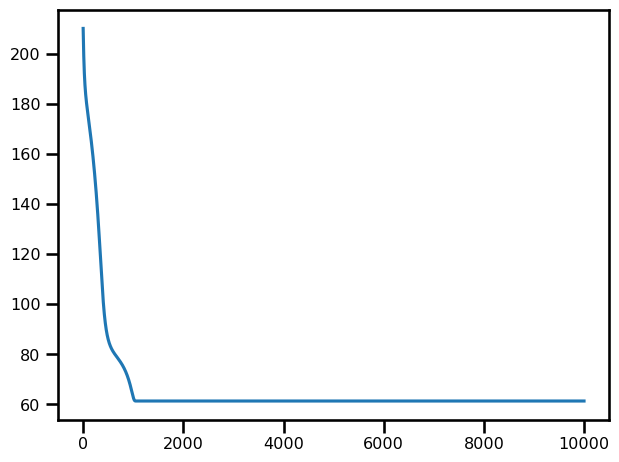

In [54]:
fig, ax = plt.subplots()
ax.plot(svi_result.losses)
plt.tight_layout()
plt.show()

### Params

In [55]:
c = svi_result.params["concentration"]
loc = svi_result.params["loc"]
scale = svi_result.params["scale"]

In [56]:
print("Parameters (MLE):")
print(f"Shape - ξ: {c:.4f}")
print(f"Loc   - μ: {loc:.4f}")
print(f"Scale - σ: {scale:.4f}")

Parameters (MLE):
Shape - ξ: -0.1762
Loc   - μ: 38.0390
Scale - σ: 1.0167


## Return Period

In [57]:
import numpy as np
from scipy.stats import genextreme

# simple return periods
return_periods = np.logspace(-0.999, 2, 100)

model = tfd.GeneralizedExtremeValue(loc=loc, scale=scale, concentration=c)
return_levels = model.quantile(1-1/return_periods)

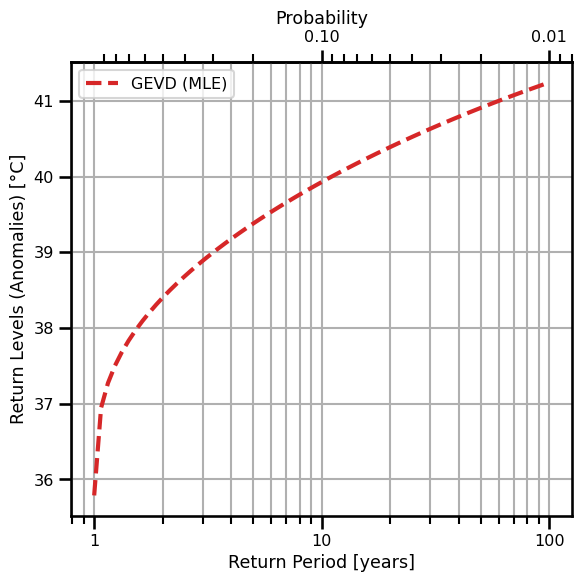

In [58]:


fig, ax = plt.subplots(figsize=(6,6))

ax.plot(
    return_periods, return_levels, 
    linestyle="--", linewidth=3, color="tab:red",
    label="GEVD (MLE)",
)


ax.set(
    xlabel="Return Period [years]",
    ylabel="Return Levels (Anomalies) [°C]",
    xscale="log",
)

# SECOND AXIS
def safe_reciprocal(x):
    """Vectorized 1/x, treating x==0 manually"""
    x = np.array(x, float)
    near_zero = np.isclose(x, 0)
    x[near_zero] = np.inf
    x[~near_zero] = np.reciprocal(x[~near_zero])
    return x

secax = ax.secondary_xaxis("top", functions=(safe_reciprocal, safe_reciprocal))
secax.set_xlabel("Probability")
secax.set_xticks([0.1, 0.01])

# format log scale labels
formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.xaxis.set_major_formatter(formatter)
secax.xaxis.set_major_formatter(formatter)

plt.grid(which="both", visible=True)
plt.legend()
plt.tight_layout()
plt.show()